In [2]:
%run './model/multi_corpus.py'
%run './constants.py'

from scipy.cluster.hierarchy import linkage, dendrogram

from matplotlib import cm

from itertools import combinations

In [3]:
corpora = co_occurence_graphs(n_edges=100)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 57 nodes and 100 edges
Geometry Graph with 61 nodes and 100 edges
Geophysics Graph with 63 nodes and 100 edges
Economics Graph with 50 nodes and 100 edges
Language & Linguistics Graph with 58 nodes and 100 edges
Probability & Statistics Graph with 58 nodes and 100 edges
Material Engineering Graph with 49 nodes and 100 edges
Artificial Intelligence Graph with 49 nodes and 100 edges
Sociology Graph with 76 nodes and 100 edges
International Business Graph with 51 nodes and 100 edges
Political Science Graph with 56 nodes and 100 edges
Genetics & Genomics Graph with 71 nodes and 100 edges
Immunology Graph with 92 nodes and 100 edges
Human Resources & Organizations Graph with 66 nodes and 100 edges
Ethnic & Cultural Studies Graph with 52 nodes and 100 edges
Neurology Graph with 46 nodes and 100 edges


Nodes:  76
Levels:  71


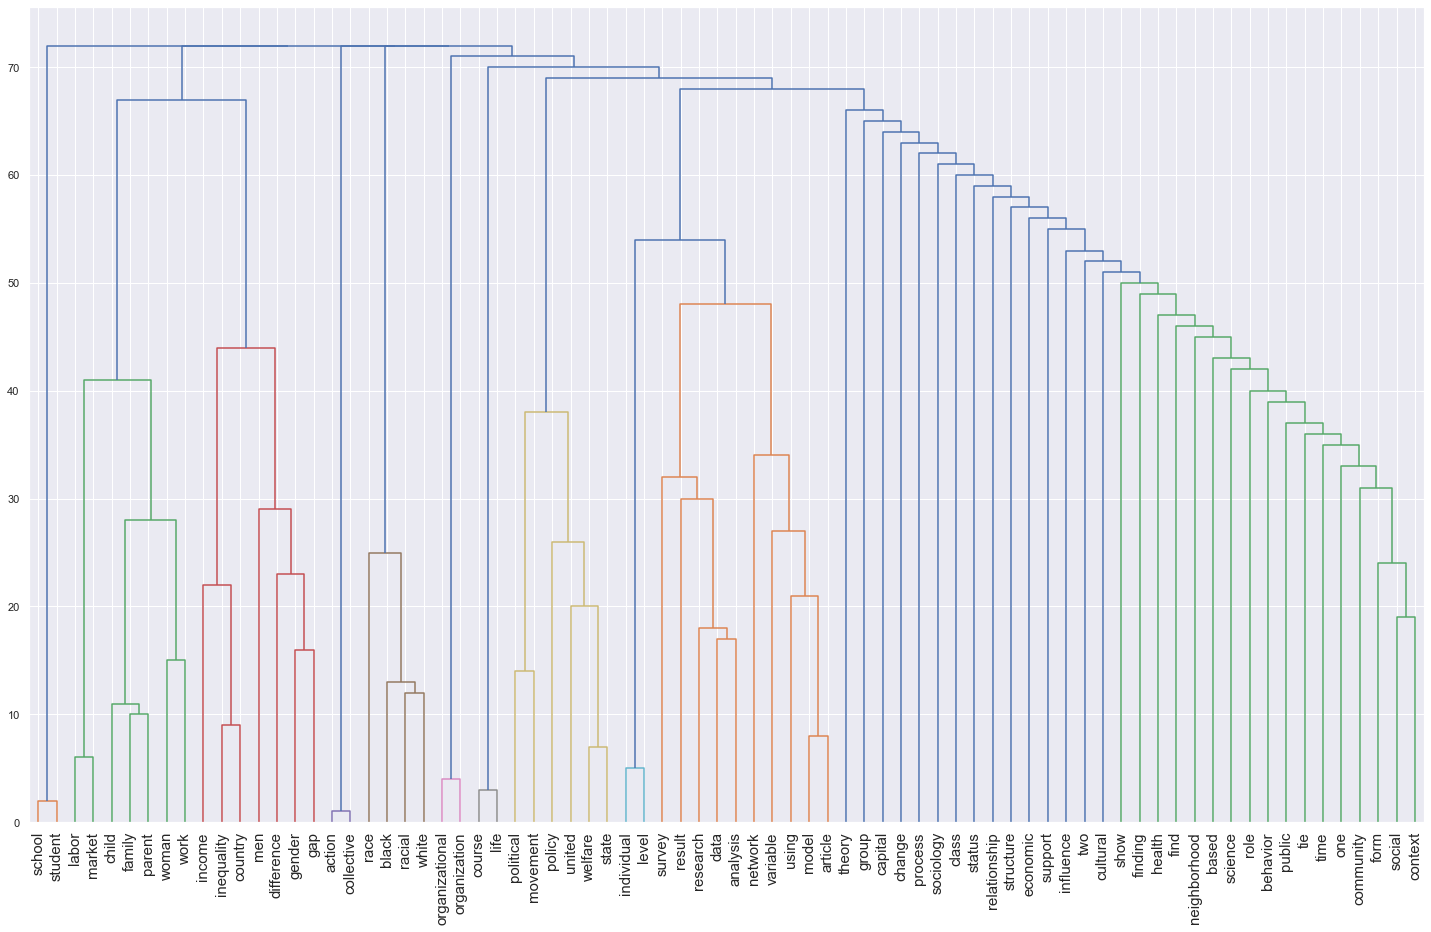

In [4]:
import itertools
import scipy

G = Gs['Sociology']

method = 'grivan_newman' # louvain, girvan_newman

if method == 'louvain':
    hier_comms = list(nx.community.louvain_partitions(G, weight='weight', resolution=1, threshold=1e-07, seed=None))
    hier_comms.append([{node} for community in hier_comms[-1] for node in community])
if method == 'grivan_newman':
    hier_comms = list(nx.community.girvan_newman(G))

print('Nodes: ', len(G))
print('Levels: ', len(hier_comms)-1)

nodes = set.union(*hier_comms[-1])
ids = dict(zip(nodes, range(len(nodes))))

M_dst = np.full((len(nodes), len(nodes)), len(hier_comms))

dsts = []
modularities = []
for i, level in enumerate(hier_comms):
    modularity = nx.community.modularity(G, level, weight='weight', resolution=1)
    modularities.append(modularity)
    dst = len(hier_comms) - i - 1
    for cluster in level:
        for u, v in itertools.combinations(cluster, 2):
            M_dst[ids[u]][ids[v]] = dst
            M_dst[ids[v]][ids[u]] = dst
    dsts.append(dst)

np.fill_diagonal(M_dst, 0)
A_dst = scipy.spatial.distance.squareform(M_dst)
M_linkage = scipy.cluster.hierarchy.linkage(A_dst)

fig, ax = plt.subplots(1, figsize=(25, 15))
scipy.cluster.hierarchy.dendrogram(M_linkage, labels=list(ids.keys()), leaf_rotation=90., leaf_font_size=15)
plt.show()

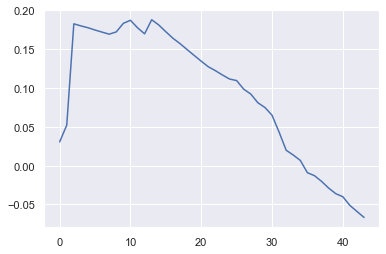

In [33]:
x = range(len(modularities))
y = modularities

plt.plot(x, y)
plt.show()

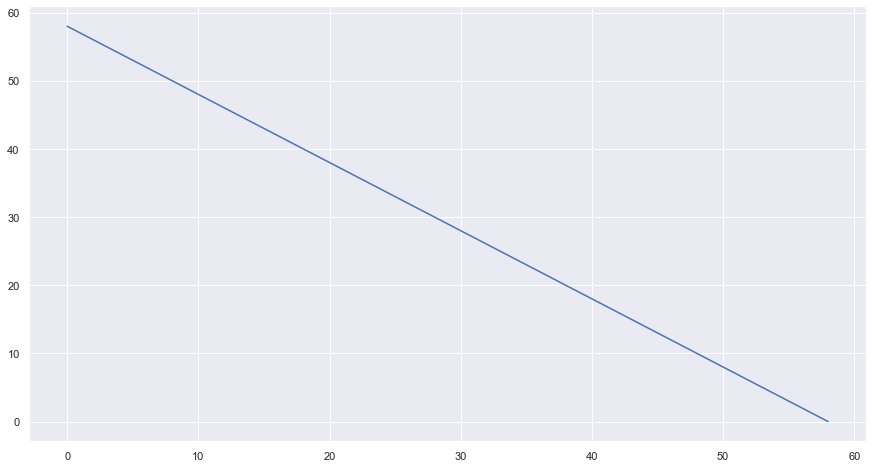

In [630]:
x = range(len(dsts))
y = dsts

plt.plot(x, y)
plt.show()

In [415]:
field_name = 'Sociology'

G = Gs[field_name]
df = Dfs[field_name]

In [70]:
import networkx as nx
from community import community_louvain
from itertools import combinations

def merge_communities(graph):
    # Identify the Louvain communities
    # partition = community_louvain.best_partition(graph)
    partition = {}
    for i, community in enumerate(nx.community.louvain_communities(G)):
        for node in community:
            partition[node] = i

    # Create a dictionary of communities to nodes
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    # Create a new graph to hold the super-nodes
    super_graph = nx.Graph()

    # Iterate over each community
    for community, nodes in communities.items():
        # Create a super-node in the new graph
        super_graph.add_node(community, size=len(nodes))

        # Calculate the total weight of the edges within the community
        total_weight = sum(graph[u][v]['weight'] for u, v in combinations(nodes, 2) if graph.has_edge(u, v))

        # Create a self-loop edge on the super-node with the total weight
        super_graph.add_edge(community, community, weight=total_weight)

    # Iterate over each pair of communities
    for community1, community2 in combinations(communities.keys(), 2):
        # Calculate the total weight of the edges between the communities
        total_weight = sum(graph[u][v]['weight'] for u in communities[community1] for v in communities[community2] if graph.has_edge(u, v))

        # Create an edge between the super-nodes with the total weight
        if total_weight > 0:
            super_graph.add_edge(community1, community2, weight=total_weight)

    return super_graph, partition


In [71]:
G_merged, partition = merge_communities(G)

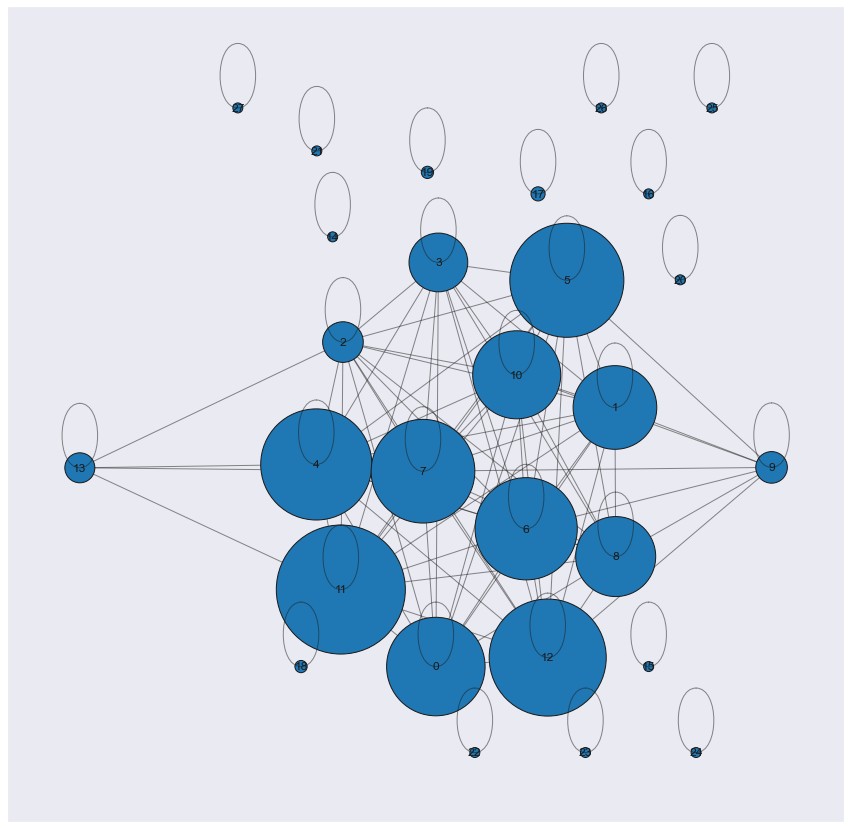

In [65]:
node_sizes = {n: d['size'] * 50 for n, d in G_merged.nodes(data=True)}
nodelist = list(node_sizes.keys())
node_size = list(node_sizes.values())

edge_sizes = {(u, v): d['weight'] * 50 for u, v, d in G_merged.edges(data=True)}
edgelist = list(edge_sizes.keys())
edge_size = list(edge_sizes.values())

fig, ax = plt.subplots(1, figsize=(15, 15))

pos = nx.nx_agraph.graphviz_layout(G_merged, prog='sfdp') # dot, twopi, fdp, sfdp, circo

nx.draw_networkx_nodes(
    G_merged, 
    pos,
    nodelist=nodelist,
    node_size=node_size,
    # node_color='#00ABB3',
    # node_color=node_color,
    node_shape='o',
    alpha=None,
    cmap=plt.cm.Blues,
    ax=ax,
    linewidths=1.0,
    edgecolors='k',
).set_zorder(1)

nx.draw_networkx_labels(G_merged, pos=pos, ax=ax, labels=dict(zip(nodelist, nodelist)))

nx.draw_networkx_edges(
    G_merged, 
    pos,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.5,
    arrowsize=10,
    ax=ax,
    nodelist=nodelist,
    node_size=node_size,
    node_shape='o',
    connectionstyle='arc3',
    # width=width,
).set_zorder(-1)

ax.grid(False)

plt.show()
# plt.savefig(
#     os.path.join(LATEX_FIGURES_PATH, 'co_occurrence_graphs', f'{field_name.capitalize()}.png'), 
#     transparent=True, 
#     dpi=150 
# )

{0: array([ 0.22928548, -0.48917414]), 1: array([ 0.50374666, -0.36524541]), 2: array([ 0.34166116, -0.5630131 ]), 3: array([ 0.55296532, -0.22962515]), 4: array([ 0.4399421 , -0.29915245]), 5: array([ 0.3601269 , -0.04616869]), 6: array([ 0.28689782, -0.12055434]), 7: array([ 0.13254958, -0.15794506]), 8: array([ 0.27214309, -0.38222531]), 9: array([ 0.2150837 , -0.23118393]), 10: array([ 0.23359202, -0.09218235]), 11: array([ 0.1281633 , -0.04309708]), 12: array([ 0.35569128, -0.34329451]), 13: array([ 0.37778225, -0.23531604]), 14: array([ 0.29634347, -0.48130414]), 15: array([ 0.29190737, -0.60410811]), 16: array([ 0.34401225, -0.41008156]), 17: array([ 0.33550944, -0.18932138]), 18: array([ 0.28714502, -0.31777662]), 19: array([ 0.20270498, -0.37855569]), 20: array([ 0.20692559, -0.29929308]), 21: array([ 0.37804707, -0.45086212]), 22: array([ 0.22441006, -0.17509922]), 23: array([ 0.44188936, -0.38819432]), 24: array([ 0.49429854, -0.1742495 ]), 25: array([ 0.0746733 , -0.5651876

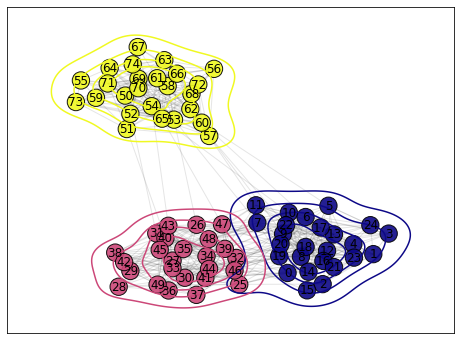

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

# Define parameters
sizes = [25, 25, 25]
p_matrix = [
    [0.5, 0.1, 0.01], 
    [0.1, 0.5, 0.01],
    [0.01, 0.01, 0.5],
]

# Create a stochastic block model
G = nx.stochastic_block_model(sizes, p_matrix, seed=0)
nx.write_weighted_edgelist(G, './link_clustering/weighted_edgelist.edgelist', delimiter='\t')

# Use the Louvain method for community detection
communities = nx.community.louvain_communities(G)
communities = {n: i for i, comm in enumerate(communities) for n in comm}

# Get the number of communities
num_communities = len(set(communities.values()))
cmap = cm.get_cmap('plasma', num_communities)
color_map = [cmap(communities[node]) for node in G]

pos = nx.spring_layout(G)
print(pos)
# KDE
pos_array = defaultdict(list)
for n, coord in pos.items():
    if n == 25:
        pos_array[0].append(coord)    
    pos_array[communities[n]].append(coord)

plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(G, pos=pos, node_color=color_map, alpha=0.9, edgecolors='k')
nx.draw_networkx_edges(G, pos=pos, alpha=0.1)
nx.draw_networkx_labels(G, pos=pos)

for comm, arr in pos_array.items():
    
    df = pd.DataFrame(arr)
    df.columns = ['x', 'y']

    sns.kdeplot(data=df, x="x", y="y", levels=5, thresh=0.1, color=cmap(comm)) # , fill=True

plt.show()

In [60]:
df_comm = (
    pl.DataFrame([
        pl.Series('Doi', list(comms_dict.keys())),
        pl.Series('Community', list(comms_dict.values())),
    ])
    .join(df, on='Doi', how='left')
    .select(
        pl.col('Doi'), 
        pl.col('Community'), 
        pl.col('Text'),
    )
    .groupby('Community')
    .agg(
        pl.col('Doi'), 
        pl.col('Text')
    )
    .with_columns(
        pl.col('Text')
        .arr.eval(pl.element().explode())
    )
    .sort(pl.col('Doi').arr.lengths(), descending=True)
)
df_comm

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_72773/511935844.py:19: DeprecationWarning: `Series/Expr.explode()` is deprecated in favor of the identical method under the list and string namespaces. Use `.arr.explode()` or `.str.explode()` instead.
  .arr.eval(pl.element().explode())


Community,Doi,Text
i64,list[str],list[str]
8,"[""10.1177/000312240907400106"", ""10.1353/sof.2005.0048"", ... ""10.1086/367919""]","[""street"", ""suite"", ... ""outcome""]"
1,"[""10.1086/595941"", ""10.1086/597175"", ... ""10.1086/669506""]","[""cumulative"", ""gender"", ... ""state""]"
4,"[""10.1146/annurev-soc-071312-145611"", ""10.1086/670719"", ... ""10.2307/3088896""]","[""housing"", ""commodity"", ... ""discussed""]"
0,"[""10.1146/annurev.soc.32.061604.123101"", ""10.1086/673971"", ... ""10.2307/3088931""]","[""legitimacy"", ""social"", ... ""interplay""]"
6,"[""10.2307/3088937"", ""10.1086/210314"", ... ""10.1086/669605""]","[""two"", ""decade"", ... ""discussed""]"
5,"[""10.1177/000312240907400403"", ""10.1177/0003122412453921"", ... ""10.1086/428817""]","[""resource"", ""variation"", ... ""community""]"
7,"[""10.1146/annurev-soc-071913-043406"", ""10.1146/annurev.soc.31.041304.122232"", ... ""10.2307/2096348""]","[""doe"", ""schooling"", ... ""health""]"
2,"[""10.1146/annurev-soc-071811-145516"", ""10.2307/2657291"", ... ""10.2307/3088956""]","[""outsourcing"", ""social"", ... ""development""]"
10,"[""10.1353/sof.2006.0002"", ""10.1353/sof.2003.0012"", ... ""10.1353/sof.2001.0070""]","[""distorted"", ""nation"", ... ""contingent""]"


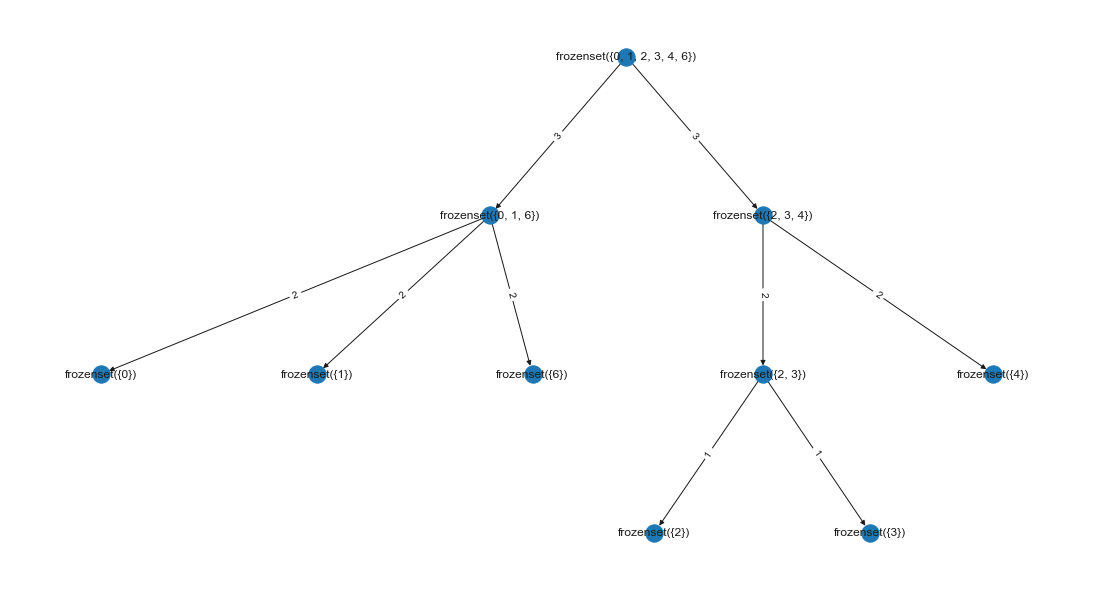

In [461]:
clusters = [
    ({0, 1, 6, 2, 3, 4},),
    ({0, 1, 6}, {2, 3, 4}),
    ({0, 1, 6}, {2, 3}, {4}),
    ({0}, {1}, {6}, {2}, {3}, {4}),
]

clusters = [tuple([frozenset(cluster) for cluster in level]) for level in clusters]

root = clusters[0][0]
n_levels = len(clusters)

G = nx.DiGraph()

for i in range(len(clusters)-1):
    for parent in clusters[i]:
        for child in clusters[i+1]:
            if set(child).issubset(set(parent)):
                if child != parent:
                    G.add_edge(parent, child)
                    G[parent][child]['weight'] = n_levels - (len(nx.shortest_path(G, root, child)) - 1)


pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(G, with_labels=True, pos=pos)

edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='k'
)

plt.show()

In [472]:
G

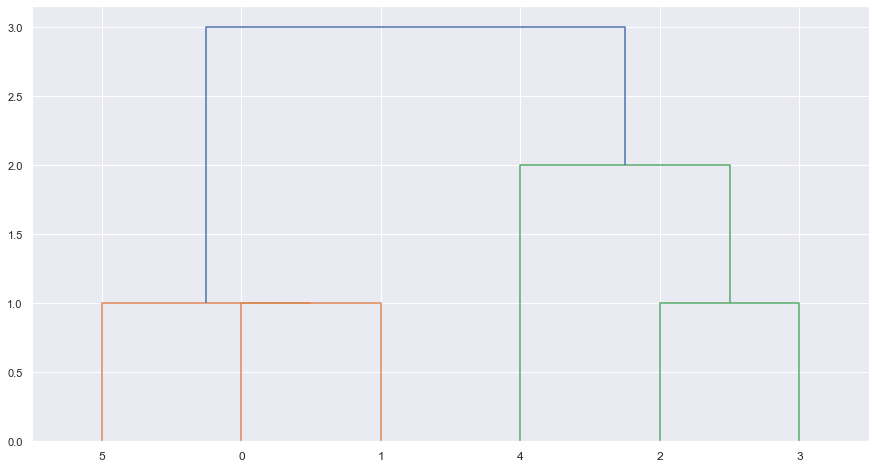

In [471]:
M_dst = [
    # 0  1  2  3  4  6
    [ 0, 1, 3, 3, 3, 1], # 0
    [ 1, 0, 3, 3, 3, 1], # 1
    
    [ 3, 3, 0, 1, 2, 3], # 2
    [ 3, 3, 1, 0, 2, 3], # 3

    [ 3, 3, 2, 2, 0, 3], # 4

    [ 1, 1, 3, 3, 3, 0], # 6
]

A_dst = scipy.spatial.distance.squareform(M_dst)

M_linkage = scipy.cluster.hierarchy.linkage(A_dst)

scipy.cluster.hierarchy.dendrogram(M_linkage)

plt.show()

In [136]:
sns.reset_defaults()
cmap = cm.plasma

node_size = 50

# pos = nx.nx_agraph.graphviz_layout(Gc, prog="twopi") # dot, twopi, fdp, sfdp, circo
pos = nx.multipartite_layout(Gc, subset_key="layer", align="horizontal")


plt.figure(figsize=(15, 15))

nodes = nx.draw_networkx_nodes(
    Gc, 
    pos, 
    # nodelist=nodes_with_term,
    node_size=node_size,
    node_color='red',
    node_shape='o',
    alpha=None,
    # cmap=cmap,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=1.0, 
    edgecolors='k', 
    # label=None, 
    margins=None
)
nodes.set_zorder(1)

edges = nx.draw_networkx_edges(
    Gc, 
    pos,
    edgelist=None,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.5,
    arrowstyle=None,
    arrowsize=10,
    edge_cmap=None,
    edge_vmin=None,
    edge_vmax=None,
    ax=None,
    arrows=None,
    label=None,
    node_size=node_size,
    nodelist=None,
    node_shape='o',
    connectionstyle='arc3',
    min_source_margin=0,
    min_target_margin=0,
)

for c in edges:
    c.set_zorder(-1)
# edges.set_zorder(-1)

plt.legend()

plt.grid(False)
plt.box(False)

# root = root.replace('/', '-')

plt.show()
# plt.savefig(
#     os.path.join(LATEX_FIGURES_PATH, 'genealogy_trees', f'{root}.png'), 
#     transparent=True, 
#     dpi=300,
#     bbox_inches='tight',
# )

ValueError: all nodes must have subset_key (default='subset') as data

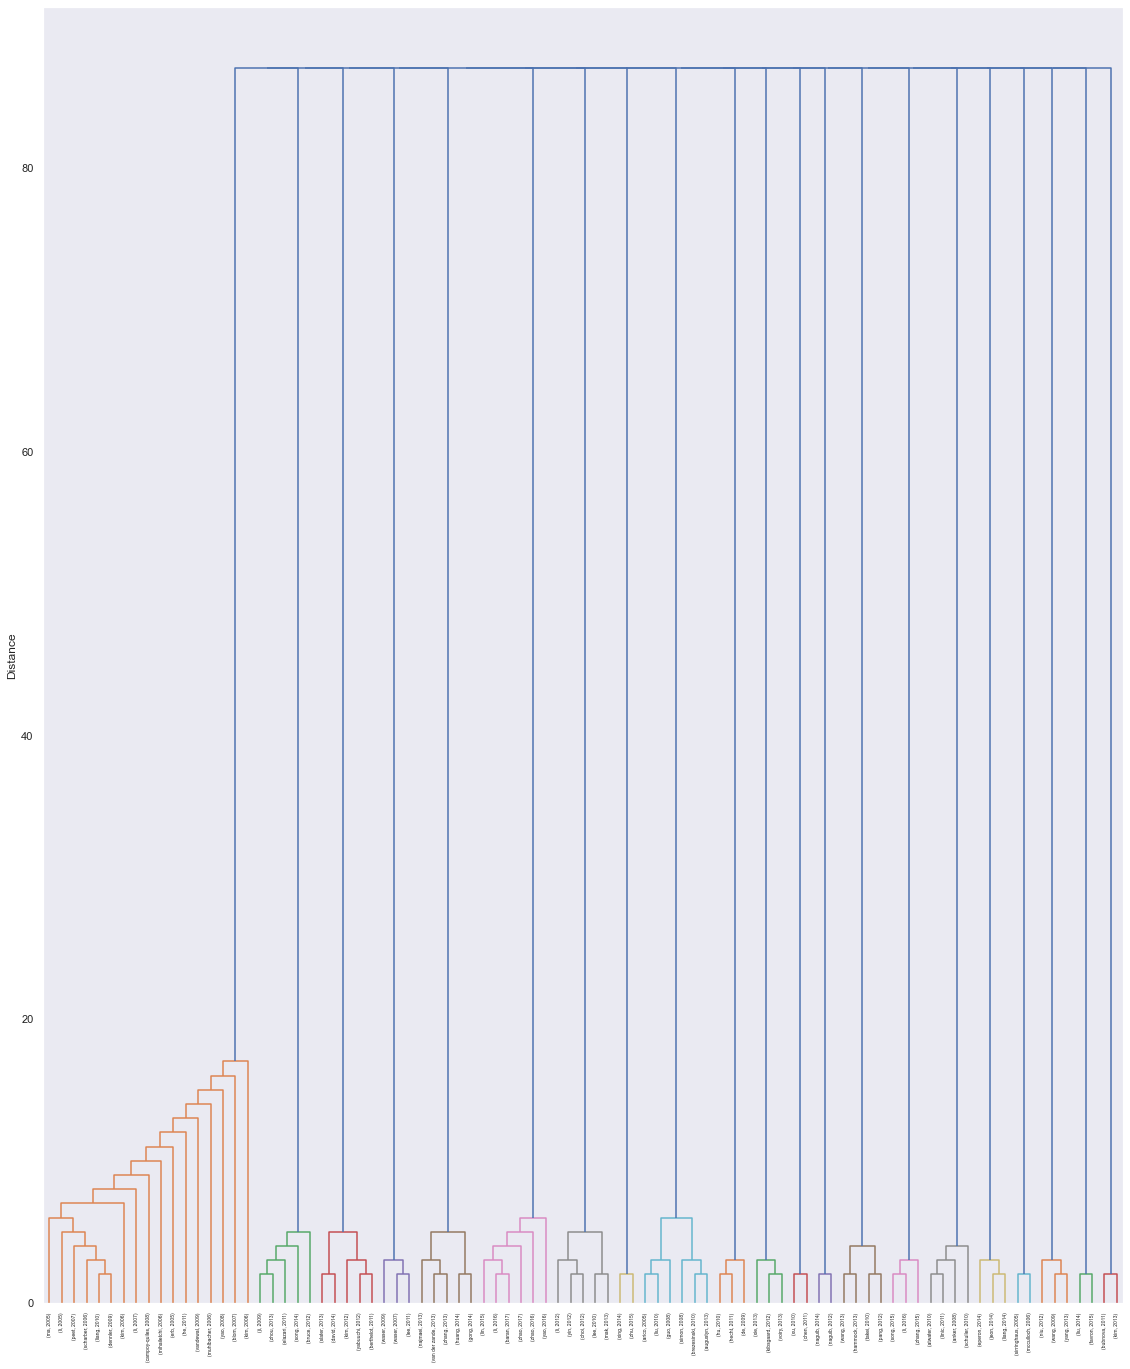

In [10]:

new_leaves = dict(
    pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
    .select(
        pl.col('Doi'), 
        pl.concat_str([
            pl.lit('('),
            pl.col('Authors').arr.first().str.split(', ').arr.first(),
            pl.lit(', '),
            pl.col('Date').dt.year(),
            pl.lit(')')
        ])
    )
    .filter(pl.col('Doi').is_in(leaves))
    .to_numpy()
)

leaves = dict(zip(leaves, leaves))
leaves.update(new_leaves)

fig = plt.figure(figsize=(15, 18))
ax = fig.add_axes([0, 0, 1, 1])

# ax.set_xlabel('Node')
ax.set_ylabel('Distance')

dendrogram(Z, labels=list(leaves.values()), ax=ax)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# fig.tight_layout()

plt.show()

In [14]:
print(nx.number_connected_components(G))

20


In [170]:
m = nx.to_numpy_array(G)

In [171]:
Z = linkage(m, method='ward')

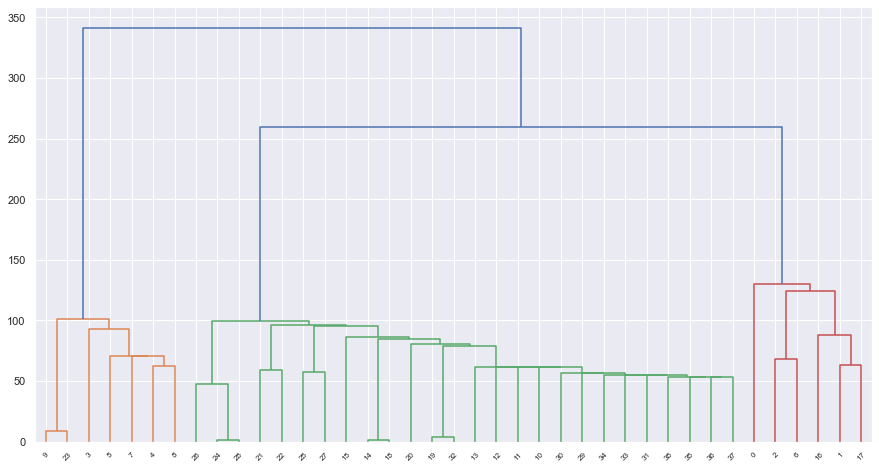

In [ ]:
dn = dendrogram(Z, labels=G.nodes)

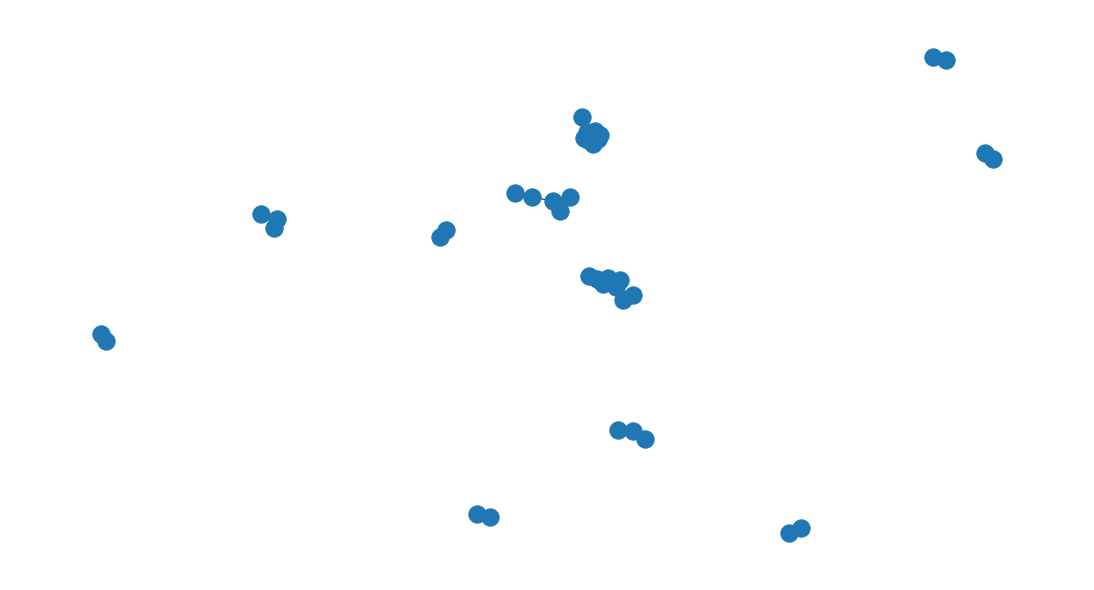

In [153]:
nx.draw(G)

In [108]:
G = Gs['Sociology']
print(G)
print(nx.number_connected_components(G))
nodes = list(G.nodes)

comms = nx.community.louvain_communities(G)
print(len(comms))

df = Dfs['Sociology']
df = df.select(pl.col('Doi'), pl.col('Text'), pl.col('References'))

labelled_comms = {}
for i, comm in enumerate(comms):
    labelled_comms.update(dict.fromkeys(comm, i))

df_comms = pl.from_dict({
    'Doi': labelled_comms.keys(),
    'Community': labelled_comms.values(),
})

df_comms = df_comms.join(df, on='Doi', how='left')

df_comms = df_comms.with_columns(pl.col('Text').arr.eval(pl.element().unique()))

df_comms = (
    df_comms
    .explode('References')
    .join(
        df_comms.select(pl.col('Doi'), pl.col('Community')),
        right_on='Doi',
        left_on='References',
        how='left',
        suffix='Reference'
    )
)

nx.set_node_attributes(G, labelled_comms, 'Community')

df_comms.head()

Graph with 2327 nodes and 21230 edges
15
27


Doi,Community,Text,References,CommunityReference
str,i64,list[str],str,i64
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.2307/209645...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1086/231084...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1146/annure...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1086/230784...",0
"""10.1086/210001...",0,"[""corresponds"", ""return"", ... ""income""]","""10.1086/230788...",0


In [125]:
df_core = (
    df_comms
    .groupby('References')
    .agg(
        pl.col('Doi'),
        pl.col('Community'),
    )
    .filter(pl.col('Community').arr.unique().arr.lengths().eq(1))
    .select(
        pl.col('References'),
        pl.lit(True).alias('Core'),
    )
)

In [135]:
dois, cores = (
    df
    .join(df_core, left_on='Doi', right_on='References', how='left')
    .fill_null(False)
    .select(
        pl.col('Doi'),
        pl.col('Core'),
    )
)

core_attrs = dict(
    zip(
        dois.to_list(),
        cores.to_list(),
    )
)

nx.set_node_attributes(G, core_attrs, 'Core')

In [ ]:
(
    df_comms
    .select(
        pl.col('Doi'),
        pl.col('Community'),
        pl.col('CommunityReference'),
    )
    .groupby(pl.col('Doi'))
    .agg(pl.all())
)

Doi,Community,CommunityReference
str,list[i64],list[i64]
"""10.1086/506413...","[7, 7, 7]","[7, 7, 7]"
"""10.1146/annure...","[1, 1, ... 1]","[1, 1, ... 1]"
"""10.1086/381914...",[6],[5]
"""10.1086/661985...","[9, 9, ... 9]","[9, 9, ... 7]"
"""10.1353/sof.20...","[5, 5, ... 5]","[5, 5, ... 5]"
"""10.2307/258035...","[1, 1, 1]","[1, 1, 1]"
"""10.1177/000312...","[5, 5, ... 5]","[5, 5, ... 5]"
"""10.1353/sof.20...","[6, 6, ... 6]","[4, 6, ... 6]"
"""10.1146/annure...","[6, 6, ... 6]","[6, 6, ... 6]"


In [73]:
nx.set_node_attributes(G, labelled_comms, 'Community')

In [68]:
df_comms.head()

Doi,Community,Text
str,i64,list[str]
"""10.2307/265733...",0,"[""variation"", ""mast"", ... ""private""]"
"""10.1086/210218...",0,"[""growth"", ""question"", ... ""rising""]"
"""10.1177/000312...",0,"[""political"", ""model"", ... ""protection""]"
"""10.1353/sof.20...",0,"[""international"", ""sense"", ... ""defining""]"
"""10.1086/649577...",0,"[""article"", ""implies"", ... ""exclusive""]"


In [72]:
(
    df_comms
    .explode('Text')
    .groupby('Text')
    .agg(pl.col('Community'))
    .filter(pl.col('Community').arr.lengths().eq(1))
    .with_columns(pl.col('Community').arr.first())
    .groupby('Community')
    .agg(pl.col('Text'))
    # .unique(subset=['Community', 'Text'])
    # .groupby('Community')
    # .agg(pl.col('Text'))
)

Community,Text
i64,list[str]
16,"[""partition"", ""goodman""]"
8,"[""antiunion"", ""nobel"", ... ""idaho""]"
0,"[""technoecology"", ""tribal"", ... ""transnationalization""]"
24,"[""assembler"", ""therapist"", ... ""retardation""]"
23,"[""overhauled"", ""deconcentration"", ... ""interactively""]"
15,"[""penalizing"", ""prwora"", ... ""diversion""]"
7,"[""deterred"", ""confounders"", ... ""externalized""]"
6,"[""postulating"", ""fun"", ... ""supervise""]"
14,"[""nonsupervisors""]"
